# Analysis for Sections 5.2.1 to 5.2.2

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# src files
from situation_testing.situation_testing import SituationTesting
# plot params
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
# working directory
wd = os.path.dirname(os.getcwd())
# relevant folders
data_path = os.path.abspath(os.path.join(wd, 'data')) + '\\'
resu_path = os.path.abspath(os.path.join(wd, 'results')) + '\\'

In [3]:
# factual dataset
org_df    = pd.read_csv(data_path + 'LoanApplication_v2.csv', sep='|', )
# counterfactual dataset
org_cf_df = pd.read_csv(data_path + 'counterfactuals\\cf_LoanApplication_v2.csv', sep='|', )

Text(0.5, 0, 'Annual salary ($X1$) for females')

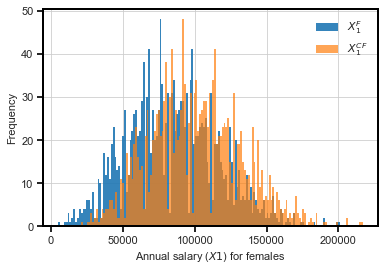

In [4]:
# distributions for X1
b = 150
plt.hist(org_df[org_df['Gender'] == 1]['AnnualSalary'], bins=b, alpha=0.9, label=r'$X_1^F$')
plt.hist(org_cf_df[org_cf_df['Gender'] == 1]['AnnualSalary'], bins=b, alpha=0.7, label=r'$X_1^{CF}$')
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel(r'Annual salary ($X1$) for females')

In [ ]:
# import seaborn as sns

# fig, ax = plt.subplots()
# sns.kdeplot(org_df[org_df['Gender'] == 1]['AnnualSalary'], alpha=0.9, label=r'$X_1^F$', ax=ax)
# sns.kdeplot(org_cf_df[org_cf_df['Gender'] == 1]['AnnualSalary'], alpha=0.7, label=r'$X_1^{CF}$', ax=ax)
# plt.legend(loc='upper right')
# plt.ylabel('Density')
# plt.xlabel(r'Annual salary ($X1$) for females')

Text(0.5, 0, 'Account balance ($X_2$) for females')

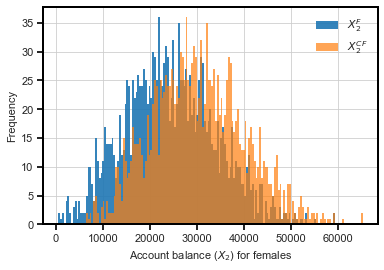

In [5]:
# distributions X2
b = 150
plt.hist(org_df[org_df['Gender'] == 1]['AccountBalance'], bins=b, alpha=0.9, label=r'$X_2^F$')
plt.hist(org_cf_df[org_cf_df['Gender'] == 1]['AccountBalance'], bins=b, alpha=0.7, label=r'$X_2^{CF}$')
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel(r'Account balance ($X_2$) for females')

In [ ]:
# import seaborn as sns

# fig, ax = plt.subplots()
# sns.kdeplot(org_df[org_df['Gender'] == 1]['AccountBalance'], alpha=0.9, label=r'$X_1^F$', ax=ax)
# sns.kdeplot(org_cf_df[org_cf_df['Gender'] == 1]['AccountBalance'], alpha=0.7, label=r'$X_1^{CF}$', ax=ax)
# plt.legend(loc='upper right')
# plt.ylabel('Density')
# plt.xlabel(r'Account balance ($X1$) for females')

We run **standard ST** (stST), **counterfactual ST** (cfST) with (w/) and without (w/o) the search centers, and **counterfactual fairness** (CF). Note that CF is already included within cfST when incuding the search centers.

In [6]:
### attribute-specific params
feat_trgt = 'LoanApproval'
feat_trgt_vals = {'positive': 1, 'negative': -1}
# list of relevant features
feat_rlvt = ['AnnualSalary', 'AccountBalance']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 0, 'protected': 1}

### st-specific params
# size of neighborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

In [7]:
res_df = org_df[['Gender', 'LoanApproval']].copy()
res_df['cf_LoanApproval'] = org_cf_df['LoanApproval'].copy()

**Other fairness measures?** Here, we only have access to $\hat{Y}$ from the ADM $b()$. There's no groundtruth $Y$. Hence, we focus on **demographic parity** (DP) where we compare the approval rates of $b()$ around gender.   

In [8]:
# f applicants
print(res_df[(res_df['Gender'] == 1) & (res_df['LoanApproval'] == 1)].shape[0] / res_df.shape[0]*100)
# m applicants
print(res_df[(res_df['Gender'] == 0) & (res_df['LoanApproval'] == 1)].shape[0] / res_df.shape[0]*100)
# and f^cf applicants
print(res_df[(res_df['Gender'] == 1) & (res_df['cf_LoanApproval'] == 1)].shape[0] / res_df.shape[0]*100)

13.498898457840976
39.97596635289405
21.029441217704786


In [9]:
# num. and % females
print(res_df[(res_df['Gender'] == 1)].shape[0])
print(res_df[(res_df['Gender'] == 1)].shape[0]/res_df.shape[0]*100)
# num. and % males
print(res_df[(res_df['Gender'] == 0)].shape[0])
print(res_df[(res_df['Gender'] == 0)].shape[0]/res_df.shape[0]*100)

1712
34.28800320448628
3281
65.71199679551371


In [10]:
org_df[['AnnualSalary', 'AccountBalance', 'Gender']].groupby('Gender').describe()

AnnualSalary                                                          \
              count           mean           std     min      25%       50%   
Gender                                                                        
0            3281.0  100655.288022  32509.337921     0.0  80000.0  100000.0   
1            1712.0   84858.936916  31634.447552  5000.0  62000.0   83500.0   

                           AccountBalance                              \
             75%       max          count          mean           std   
Gender                                                                  
0       120000.0  270000.0         3281.0  30207.080998  10049.337215   
1       106500.0  201000.0         1712.0  24302.708042   9789.640507   

                                                                             
                min           25%           50%           75%           max  
Gender                                                                       
0       1851.659180  23155.540103  29621.162415  36932.950341  76890.356632  
1        498.017847  17453.300194  23786.967583  30923.074636  59268.504239

## 5.2.1 CST w/o relative to ST

In [11]:
print("For k=", n)

test_df = org_df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['ST'] = st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                      sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                      k=n, alpha=alpha, tau=tau)

For k= 15


In [12]:
res_df[res_df['ST'] > tau].shape[0]

55

In [13]:
# check how many are significant?
temp_stats = st.get_test_discrimination()
# temp_stats.head(5)
print(temp_stats[temp_stats['DiscEvi'] == 'Yes'].shape[0])
print("vs")
print(temp_stats[(temp_stats['DiscEvi'] == 'Yes') & (temp_stats['StatEvi'] == 'Yes')].shape[0])
del temp_stats

55
vs
44


In [14]:
# get all neighborhoods for ST
stST_knn = st.res_dict_df_neighbors

In [15]:
# get the distances 
stST_dis = st.res_dict_dist_to_neighbors

In [16]:
print("For k=", n)

test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfST'] = cf_st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                           sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                           include_centers=False,
                           k=n, alpha=alpha, tau=tau)

For k= 15


In [17]:
res_df[res_df['cfST'] > tau].shape[0]

288

In [18]:
# check how many are significant?
temp_stats = cf_st.get_test_discrimination()
# temp_stats.head(5)
print(temp_stats[temp_stats['DiscEvi'] == 'Yes'].shape[0])
print("vs")
print(temp_stats[(temp_stats['DiscEvi'] == 'Yes') & (temp_stats['StatEvi'] == 'Yes')].shape[0])
del temp_stats

288
vs
272


In [19]:
# get all neighnorhoods for cfST
cfST_knn = cf_st.res_dict_df_neighbors

In [20]:
# get the distances
cfST_dis = cf_st.res_dict_dist_to_neighbors

In [21]:
# Let's consider two sets from now on:
print("For k=", n)

# Set1: c is in ST and in cfST
set1 = res_df[(res_df['ST'] > tau) & (res_df['cfST'] > tau)].index.to_list()
print(len(set1), "are in ST and cfST")

# Set2: c is not in ST but in cfST
set2 = [c for c in res_df[(res_df['cfST'] > tau)].index.to_list() if c not in set1]
print(len(set2), "are not in ST but in cfST")

For k= 15
55 are in ST and cfST
233 are not in ST but in cfST


### Figure for box-plots comparing ctr and tst grps for both methods 

In [22]:
# Number of instances to choose from
test_n = 5
# Choose between Set 1 or Set 2
# test_c = random.sample(set1, test_n)
# test_c = random.sample(set2, test_n)

# Note to reader: as this scrip is w.r.t. the paper, we use the same 5 instances
test_c = [181, 1306, 3747, 1399, 2565]

print(test_c)

var = ['AnnualSalary', 'AccountBalance']
temp_df_list = []

for c in test_c:
    
#     print('===== ===== =====')
    
#     print(stST_knn[c]['ctr_idx'])
    temp_ctr = org_df.iloc[stST_knn[c]['ctr_idx'], :][var].copy()
    temp_ctr['ID'] = str(c)
#     temp_ctr['ID'] = 'id_' + str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr
    
#     print(stST_knn[c]['tst_idx'])
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_st['ID'] = str(c)
#     temp_tst_st['ID'] = 'id_' + str(c)
    temp_tst_st['Type'] = 'tst-st'
    temp_df_list.append(temp_tst_st)
    del temp_tst_st
    
#     print(cfST_knn[c]['tst_idx'])
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_cf['ID'] = str(c)
#     temp_tst_cf['ID'] = 'id_' + str(c)
    temp_tst_cf['Type'] = 'tst-cf'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf
    
    

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

[181, 1306, 3747, 1399, 2565]


[Text(0, 0.5, 'Annual Salary ($X_1$)'), Text(0.5, 0, 'Complainant ID')]

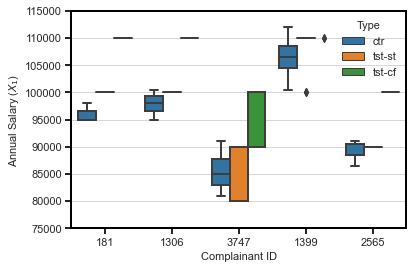

In [23]:
# box_plot_data
plt.ylim(75000, 115000)
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['AnnualSalary'],
            hue = box_plot_data['Type']
           ).set(
    ylabel = 'Annual Salary ($X_1$)', xlabel = 'Complainant ID')

[Text(0, 0.5, 'Account Balance ($X_2$)'), Text(0.5, 0, 'Complainant ID')]

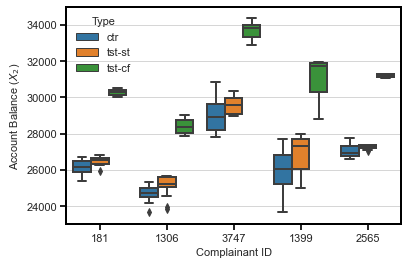

In [24]:
# box_plot_data
plt.ylim(23000, 35000)
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['AccountBalance'],
            hue = box_plot_data['Type']).set(
    ylabel = 'Account Balance ($X_2$)', xlabel = 'Complainant ID')

### Tables for summary statistics of ctr and tst grps for both methods

In [25]:
print("For k=", n)

For k= 15


In [26]:
# Get summary stats for Set 1
nsf = 2
var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']

list_temp_df = []

for c in set1:
    
    temp_df = {}
    temp_ctr    = org_df.iloc[stST_knn[c]['ctr_idx'], :][var]
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var]
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var]
    
    temp_df['id'] = c
    
    temp_df['neg_y_ctr']    = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_st'] = temp_tst_st[temp_tst_st['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_cf'] = temp_tst_cf[temp_tst_cf['LoanApproval'] == -1].shape[0]
    
    temp_df['p_ctr']    = round(temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0] / n, nsf)
    temp_df['p_tst_st'] = round(temp_tst_st[temp_tst_st['LoanApproval'] == -1].shape[0] / n, nsf)
    temp_df['p_tst_cf'] = round(temp_tst_cf[temp_tst_cf['LoanApproval'] == -1].shape[0] / n, nsf)
        
    temp_df['avg_d_ctr']    = round(sum(stST_dis[c]['ctr_idx']) / len(stST_dis[c]['ctr_idx']), nsf)
    temp_df['avg_d_tst_st'] = round(sum(stST_dis[c]['tst_idx']) / len(stST_dis[c]['tst_idx']), nsf)
    temp_df['avg_d_tst_cf'] = round(sum(cfST_dis[c]['tst_idx']) / len(cfST_dis[c]['tst_idx']), nsf)
    
    for v in ['AnnualSalary', 'AccountBalance']:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        
        temp_df['avg_tst_st_' + v] = round(temp_tst_st.mean()[v], nsf)
        temp_df['std_tst_st_' + v] = round(temp_tst_st.std()[v], nsf)
        
        temp_df['avg_tst_cf_' + v] = round(temp_tst_cf.mean()[v], nsf)
        temp_df['std_tst_cf_' + v] = round(temp_tst_cf.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set1_summary_stats = pd.DataFrame(list_temp_df)

set1_summary_stats.head(5)

,id,neg_y_ctr,neg_y_tst_st,neg_y_tst_cf,p_ctr,p_tst_st,p_tst_cf,avg_d_ctr,avg_d_tst_st,avg_d_tst_cf,...,avg_tst_st_AnnualSalary,std_tst_st_AnnualSalary,avg_tst_cf_AnnualSalary,std_tst_cf_AnnualSalary,avg_ctr_AccountBalance,std_ctr_AccountBalance,avg_tst_st_AccountBalance,std_tst_st_AccountBalance,avg_tst_cf_AccountBalance,std_tst_cf_AccountBalance
0,5,1,0,0,0.07,0.0,0.0,0.04,0.03,0.03,...,100000.00,0.00,110000.00,0.00,26179.17,896.82,25924.08,315.76,29959.04,211.08
1,147,8,0,0,0.53,0.0,0.0,0.02,0.04,0.03,...,90000.00,0.00,100000.00,0.00,27708.72,520.71,27822.32,54.95,31842.26,104.77
2,181,3,0,0,0.20,0.0,0.0,0.02,0.04,0.03,...,100000.00,0.00,110000.00,0.00,26143.68,409.24,26496.01,236.24,30284.48,159.96
3,264,7,0,0,0.47,0.0,0.0,0.03,0.05,0.04,...,90000.00,0.00,100000.00,0.00,27891.90,502.75,28101.91,34.61,32115.33,85.74
4,420,1,0,0,0.07,0.0,0.0,0.06,0.06,0.06,...,89333.33,2581.99,99333.33,2581.99,29315.62,871.13,30108.42,188.49,34093.13,389.20


In [27]:
set1_summary_stats.mean().round(nsf)

id                             2832.51
neg_y_ctr                         8.82
neg_y_tst_st                      2.22
neg_y_tst_cf                      0.00
p_ctr                             0.59
p_tst_st                          0.15
p_tst_cf                          0.00
avg_d_ctr                         0.03
avg_d_tst_st                      0.04
avg_d_tst_cf                      0.03
avg_ctr_AnnualSalary          94372.12
std_ctr_AnnualSalary           1646.29
avg_tst_st_AnnualSalary       96181.82
std_tst_st_AnnualSalary         611.57
avg_tst_cf_AnnualSalary      106569.70
std_tst_cf_AnnualSalary         286.34
avg_ctr_AccountBalance        26092.93
std_ctr_AccountBalance          558.30
avg_tst_st_AccountBalance     26347.46
std_tst_st_AccountBalance       352.78
avg_tst_cf_AccountBalance     30141.28
std_tst_cf_AccountBalance       273.45
dtype: float64

In [28]:
# Get summary stats for Set 2
nsf = 2

list_temp_df = []

var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']
# var.append('LoanApproval')

for c in set2:
    
    temp_df = {}
    temp_ctr    = org_df.iloc[stST_knn[c]['ctr_idx'], :][var]
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var]
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var]
    
    temp_df['id'] = c
    
    temp_df['neg_y_ctr']    = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_st'] = temp_tst_st[temp_tst_st['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst_cf'] = temp_tst_cf[temp_tst_cf['LoanApproval'] == -1].shape[0]
    
    temp_df['p_ctr']    = round(temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0] / n, nsf)
    temp_df['p_tst_st'] = round(temp_tst_st[temp_tst_st['LoanApproval'] == -1].shape[0] / n, nsf)
    temp_df['p_tst_cf'] = round(temp_tst_cf[temp_tst_cf['LoanApproval'] == -1].shape[0] / n, nsf)
    
    temp_df['avg_d_ctr']    = round(sum(stST_dis[c]['ctr_idx']) / len(stST_dis[c]['ctr_idx']), nsf)
    temp_df['avg_d_tst_st'] = round(sum(stST_dis[c]['tst_idx']) / len(stST_dis[c]['tst_idx']), nsf)
    temp_df['avg_d_tst_cf'] = round(sum(cfST_dis[c]['tst_idx']) / len(cfST_dis[c]['tst_idx']), nsf)
    
    for v in ['AnnualSalary', 'AccountBalance']:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        
        temp_df['avg_tst_st_' + v] = round(temp_tst_st.mean()[v], nsf)
        temp_df['std_tst_st_' + v] = round(temp_tst_st.std()[v], nsf)
        
        temp_df['avg_tst_cf_' + v] = round(temp_tst_cf.mean()[v], nsf)
        temp_df['std_tst_cf_' + v] = round(temp_tst_cf.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set2_summary_stats = pd.DataFrame(list_temp_df)
set2_summary_stats.head(5)

,id,neg_y_ctr,neg_y_tst_st,neg_y_tst_cf,p_ctr,p_tst_st,p_tst_cf,avg_d_ctr,avg_d_tst_st,avg_d_tst_cf,...,avg_tst_st_AnnualSalary,std_tst_st_AnnualSalary,avg_tst_cf_AnnualSalary,std_tst_cf_AnnualSalary,avg_ctr_AccountBalance,std_ctr_AccountBalance,avg_tst_st_AccountBalance,std_tst_st_AccountBalance,avg_tst_cf_AccountBalance,std_tst_cf_AccountBalance
0,9,15,15,14,1.0,1.0,0.93,0.03,0.05,0.05,...,80000.00,0.00,91333.33,3518.66,21184.53,582.35,21309.10,119.28,25060.94,92.93
1,44,15,15,0,1.0,1.0,0.00,0.02,0.01,0.01,...,90000.00,0.00,100000.00,0.00,26136.55,401.03,26097.84,86.93,30049.62,70.98
2,50,15,15,0,1.0,1.0,0.00,0.02,0.01,0.00,...,90000.00,0.00,100000.00,0.00,23323.32,500.22,23318.61,211.77,27130.95,125.06
3,55,12,15,0,0.8,1.0,0.00,0.02,0.04,0.04,...,90000.00,0.00,100000.00,0.00,25779.09,580.91,25726.01,60.72,29655.55,50.06
4,89,15,15,0,1.0,1.0,0.00,0.06,0.05,0.06,...,79333.33,2581.99,89333.33,2581.99,26221.46,838.44,27111.46,104.83,31205.64,514.59


In [29]:
set2_summary_stats.mean().round(nsf)

id                            2456.38
neg_y_ctr                       13.74
neg_y_tst_st                    14.79
neg_y_tst_cf                     0.78
p_ctr                            0.92
p_tst_st                         0.99
p_tst_cf                         0.05
avg_d_ctr                        0.03
avg_d_tst_st                     0.03
avg_d_tst_cf                     0.03
avg_ctr_AnnualSalary         86332.47
std_ctr_AnnualSalary          1524.33
avg_tst_st_AnnualSalary      85911.30
std_tst_st_AnnualSalary        906.11
avg_tst_cf_AnnualSalary      96898.43
std_tst_cf_AnnualSalary        391.49
avg_ctr_AccountBalance       24734.11
std_ctr_AccountBalance         482.15
avg_tst_st_AccountBalance    24790.05
std_tst_st_AccountBalance      152.07
avg_tst_cf_AccountBalance    28677.11
std_tst_cf_AccountBalance      171.61
dtype: float64

## 5.2.2 CST w/ relative to CF

In [30]:
print("For k=", n)

test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

# include the centers
cf_st_with = SituationTesting()
cf_st_with.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfSTwith'] = cf_st_with.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                                    sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                                    include_centers=True,
                                    k=n, alpha=alpha, tau=tau)

For k= 15


In [31]:
res_df[res_df['cfSTwith'] > tau].shape[0]

420

In [32]:
# check how many are significant?
temp_stats = cf_st_with.get_test_discrimination()
# temp_stats.head(5)
print(temp_stats[temp_stats['DiscEvi'] == 'Yes'].shape[0])
print("vs")
print(temp_stats[(temp_stats['DiscEvi'] == 'Yes') & (temp_stats['StatEvi'] == 'Yes')].shape[0])
del temp_stats

420
vs
272


In [33]:
# get all neighnorhoods for cfST
cfST_knn_with = cf_st_with.res_dict_df_neighbors

In [34]:
# get the distances
cfST_dis_with = cf_st.res_dict_dist_to_neighbors

In [35]:
# add the counterfactual fairness results
res_df['CF'] = cf_st_with.res_counterfactual_unfairness

In [36]:
# number of counterfactuals: under a CF defitinion of discrimination
res_df[res_df['CF'] == 1].shape[0]

376

In [37]:
# all results so far...
res_df.head(5)

,Gender,LoanApproval,cf_LoanApproval,ST,cfST,cfSTwith,CF
0,1,-1.0,-1.0,0.0,0.0,0.0,0.0
1,0,1.0,1.0,0.0,0.0,0.0,0.0
2,0,-1.0,-1.0,0.0,0.0,0.0,0.0
3,0,-1.0,-1.0,0.0,0.0,0.0,0.0
4,1,1.0,1.0,0.0,0.0,0.0,0.0


In [38]:
# We consider two sets of interest once again:
print("For k=", n)

# total disc cases under cfST
print(len(res_df[(res_df['cfSTwith'] > tau)].index.to_list()))

# Set 3: c in cfST and in CF
set3 = res_df[(res_df['cfSTwith'] > tau) & (res_df['CF'] == 1)].index.to_list()
print(len(set3))

# Set 4: c not in CF but in cfST
set4 = [c for c in res_df[(res_df['cfSTwith'] > tau)].index.to_list() if c not in set3]
print(len(set4))

For k= 15
420
376
44


### Tables for summary statistics of ctr and tst groups for both methods

In [39]:
nsf = 2
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']

for c in set3:
    
    temp_df['id'] = c
    
    temp_df = {}
    
    temp_ctr         = org_df.iloc[cfST_knn_with[c]['ctr_idx'], :][var].copy()
    # include the ctr search center
    temp_ctr         = temp_ctr.append(org_df.iloc[c][var])
    
    temp_tst_cf_with = org_cf_df.iloc[cfST_knn_with[c]['tst_idx'], :][var].copy()
    # include the tst search center
    temp_tst_cf_with = temp_tst_cf_with.append(org_cf_df.iloc[c][var]) 
        
    temp_df['num_neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval']==-1].shape[0]
    temp_df['num_neg_y_tst'] = temp_tst_cf_with[temp_tst_cf_with['LoanApproval']==-1].shape[0] 
    
    temp_df['pro_neg_y_ctr'] = round(temp_df['num_neg_y_ctr'] / (n + 1), nsf)
    temp_df['pro_neg_y_tst'] = round(temp_df['num_neg_y_tst'] / (n + 1), nsf) 
    
    for v in ['AnnualSalary', 'AccountBalance']:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        temp_df['avg_tst_' + v] = round(temp_tst_cf_with.mean()[v], nsf)
        temp_df['std_tst_' + v] = round(temp_tst_cf_with.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set3_summary_stats = pd.DataFrame(list_temp_df)
# set3_summary_stats.head(5)
set3_summary_stats.mean().round(nsf)

num_neg_y_ctr                15.46
num_neg_y_tst                 5.75
pro_neg_y_ctr                 0.97
pro_neg_y_tst                 0.36
avg_ctr_AnnualSalary      83281.25
std_ctr_AnnualSalary       1410.97
avg_tst_AnnualSalary      94323.46
std_tst_AnnualSalary       1564.37
avg_ctr_AccountBalance    23752.64
std_ctr_AccountBalance      449.85
avg_tst_AccountBalance    27762.60
std_tst_AccountBalance      550.18
id                         2452.70
dtype: float64

In [40]:
nsf = 2

list_temp_df = []
var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']

for c in set4:
    
    temp_df = {}
    
    temp_df['id'] = c
    
    temp_ctr         = org_df.iloc[cfST_knn_with[c]['ctr_idx'], :][var].copy()
    # include the ctr search center
    temp_ctr         = temp_ctr.append(org_df.iloc[c][var])
    
    temp_tst_cf_with = org_cf_df.iloc[cfST_knn_with[c]['tst_idx'], :][var].copy()
    # include the tst search center
    temp_tst_cf_with = temp_tst_cf_with.append(org_cf_df.iloc[c][var]) 
    
    temp_df['num_neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval']==-1].shape[0]
    temp_df['num_neg_y_tst'] = temp_tst_cf_with[temp_tst_cf_with['LoanApproval']==-1].shape[0] 
    
    temp_df['pro_neg_y_ctr'] = round(temp_df['num_neg_y_ctr'] / (n + 1), nsf)
    temp_df['pro_neg_y_tst'] = round(temp_df['num_neg_y_tst'] / (n + 1), nsf) 
    
    for v in ['AnnualSalary', 'AccountBalance']:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        temp_df['avg_tst_' + v] = round(temp_tst_cf_with.mean()[v], nsf)
        temp_df['std_tst_' + v] = round(temp_tst_cf_with.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set4_summary_stats = pd.DataFrame(list_temp_df)
# set4_summary_stats.head(5)
set4_summary_stats.mean().round(nsf)

id                          2795.89
num_neg_y_ctr                  5.23
num_neg_y_tst                  0.00
pro_neg_y_ctr                  0.33
pro_neg_y_tst                  0.00
avg_ctr_AnnualSalary       92892.05
std_ctr_AnnualSalary        1592.33
avg_tst_AnnualSalary      104541.25
std_tst_AnnualSalary        1434.18
avg_ctr_AccountBalance     26890.63
std_ctr_AccountBalance       509.61
avg_tst_AccountBalance     31161.38
std_tst_AccountBalance       545.73
dtype: float64

In [41]:
# Can we say anuthing about Sets 3 and 4? Consider the average CF:

def bank_adm(x1, x2):
    # x1: annual salary
    # x2: account balance
    return np.sign(x1 + 5*x2 - 225000)

# === Set 3
# ctr
print(bank_adm(83281.25, 23752.64))
# tst
print(bank_adm(94323.46, 27762.60))

# === Set 4
# ctr
print(bank_adm(92892.05, 26890.63))
# tst
print(bank_adm(104541.25, 31161.38))

-1.0
1.0
1.0
1.0


In [42]:
df_cf_sf_disc = cf_st_with.get_test_discrimination()
# df_cf_sf_disc.head(5)

# show the CI for the CF results
df_cf_sf_disc[df_cf_sf_disc['individual'].isin(res_df[res_df['CF'] == 1].index.to_list())].head(20)

# df_cf_sf_disc[df_cf_sf_disc['individual'].isin(res_df[res_df['CF'] == 1].index.to_list()) & (df_cf_sf_disc['StatEvi'] == 'Yes')]

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
4,9,1.0000,0.8750,0.1250,-0.011,"[-0.037, 0.287]",Yes,No
14,44,1.0000,0.0000,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
15,47,1.0000,0.9375,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
17,50,1.0000,0.0000,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
19,55,0.8125,0.0000,0.8125,0.652,"[0.621, 1.004]",Yes,Yes
30,89,1.0000,0.0000,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
33,94,1.0000,0.0000,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
40,121,1.0000,0.0000,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
44,134,1.0000,0.0000,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
45,141,1.0000,0.0000,1.0000,1.000,"[1.0, 1.0]",Yes,Yes


In [43]:
# show cases detected by CST w/ and not CF with their CIs
df_cf_sf_disc[df_cf_sf_disc['individual'].isin(res_df[(res_df['CF']==0.0) & (res_df['cfSTwith'] > tau)].index.to_list())]

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
2,5,0.0625,0.0,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
47,147,0.5000,0.0,0.5000,0.294,"[0.255, 0.745]",Yes,Yes
56,181,0.1875,0.0,0.1875,0.027,"[-0.004, 0.379]",Yes,Yes
93,264,0.4375,0.0,0.4375,0.233,"[0.194, 0.681]",Yes,Yes
151,420,0.0625,0.0,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
155,435,0.3750,0.0,0.3750,0.176,"[0.138, 0.612]",Yes,Yes
173,484,0.5000,0.0,0.5000,0.294,"[0.255, 0.745]",Yes,Yes
322,926,0.1250,0.0,0.1250,-0.011,"[-0.037, 0.287]",Yes,No
377,1096,0.0625,0.0,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
439,1257,0.3125,0.0,0.3125,0.122,"[0.085, 0.54]",Yes,Yes


### 5.1.3 Confidence in results?

Most of the the output is already provided by the run file. See the results folder. Here, we just look at CST w/o and CST w/ for $k=15$ under the two discrimination definitions: literal and statistical.

In [44]:
# From the CST w/o vs ST section(s)
cf_st
cst_wo_knns = cfST_knn

In [45]:
cst_test = cf_st.get_test_discrimination()
cst_test.head(5)

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
0,0,1.000000,1.000000,0.000000,0.000,"[0.0, 0.0]",No,No
1,4,0.000000,0.000000,0.000000,0.000,"[0.0, 0.0]",No,No
2,5,0.066667,0.000000,0.066667,-0.039,"[-0.06, 0.193]",Yes,No
3,6,1.000000,1.000000,0.000000,0.000,"[0.0, 0.0]",No,No
4,9,1.000000,0.933333,0.066667,-0.039,"[-0.06, 0.193]",Yes,No


In [46]:
print(cst_test[(cst_test['DiscEvi'] == 'Yes') & (cst_test['StatEvi'] == 'No')].shape[0])
cst_test[(cst_test['DiscEvi'] == 'Yes') & (cst_test['StatEvi'] == 'No')].head(5)

16


,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
2,5,0.066667,0.000000,0.066667,-0.039,"[-0.06, 0.193]",Yes,No
4,9,1.000000,0.933333,0.066667,-0.039,"[-0.06, 0.193]",Yes,No
63,203,1.000000,0.933333,0.066667,-0.039,"[-0.06, 0.193]",Yes,No
151,420,0.066667,0.000000,0.066667,-0.039,"[-0.06, 0.193]",Yes,No
322,926,0.133333,0.000000,0.133333,-0.011,"[-0.039, 0.305]",Yes,No


In [47]:
print(cst_test[(cst_test['DiscEvi'] == 'Yes') & (cst_test['StatEvi'] == 'Yes')].shape[0])
cst_test[(cst_test['DiscEvi'] == 'Yes') & (cst_test['StatEvi'] == 'Yes')].head(5)

272


,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
14,44,1.0,0.0,1.0,1.00,"[1.0, 1.0]",Yes,Yes
17,50,1.0,0.0,1.0,1.00,"[1.0, 1.0]",Yes,Yes
19,55,0.8,0.0,0.8,0.63,"[0.598, 1.002]",Yes,Yes
30,89,1.0,0.0,1.0,1.00,"[1.0, 1.0]",Yes,Yes
33,94,1.0,0.0,1.0,1.00,"[1.0, 1.0]",Yes,Yes


In [48]:
nsf = 2
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']

knn_of_interest = cst_wo_knns
set_of_interest = cst_test[(cst_test['DiscEvi'] == 'Yes') & (cst_test['StatEvi'] == 'No')]['individual'].to_list()

for c in set_of_interest:
    
    temp_df = {}
    
    temp_df['id'] = c
    
    temp_ctr = org_df.iloc[knn_of_interest[c]['ctr_idx'], :][var]
    temp_tst = org_cf_df.iloc[knn_of_interest[c]['tst_idx'], :][var]
    
#     temp_ctr_wi = org_df.iloc[cst_wi_knns[c]['ctr_idx'], :][var]
#     temp_ctr_wi = temp_ctr_wi.append(org_df.loc[c, var])
#     temp_tst_wi = org_cf_df.iloc[cst_wi_knns[c]['tst_idx'], :][var]
#     temp_tst_wi = temp_tst_wi.append(org_cf_df.loc[c, var])
        
    # num. of negative decisions
    temp_df['neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst'] = temp_tst[temp_tst['LoanApproval'] == -1].shape[0]
    # prp. of negative decisions
    temp_df['p_ctr'] = round(temp_df['neg_y_ctr'] / n, nsf)
    temp_df['p_tst'] = round(temp_df['neg_y_tst'] / n, nsf)
#     temp_df['p_ctr_wi'] = round(temp_df['neg_y_ctr_wi'] / (n + 1), nsf)
#     temp_df['p_tst_wi'] = round(temp_df['neg_y_tst_wi'] / (n + 1), nsf)
    
    for v in ['AnnualSalary', 'AccountBalance']:
        temp_df['avg_ctr' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr' + v] = round(temp_ctr.std()[v], nsf)
        temp_df['avg_tst' + v] = round(temp_tst.mean()[v], nsf)
        temp_df['std_tst' + v] = round(temp_tst.std()[v], nsf)
    
    list_temp_df.append(temp_df)

summary_stats = pd.DataFrame(list_temp_df)

summary_stats.mean().round(nsf)

id                         2207.44
neg_y_ctr                     3.94
neg_y_tst                     2.62
p_ctr                         0.26
p_tst                         0.17
avg_ctrAnnualSalary       92808.34
std_ctrAnnualSalary        1919.18
avg_tstAnnualSalary      104750.00
std_tstAnnualSalary        1182.73
avg_ctrAccountBalance     25923.28
std_ctrAccountBalance       652.67
avg_tstAccountBalance     30121.55
std_tstAccountBalance       290.97
dtype: float64

In [49]:
nsf = 2
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']

knn_of_interest = cst_wo_knns
set_of_interest = cst_test[(cst_test['DiscEvi'] == 'Yes') & (cst_test['StatEvi'] == 'Yes')]['individual'].to_list()

for c in set_of_interest:
    
    temp_df = {}
    
    temp_df['id'] = c
    
    temp_ctr = org_df.iloc[knn_of_interest[c]['ctr_idx'], :][var]
    temp_tst = org_cf_df.iloc[knn_of_interest[c]['tst_idx'], :][var]
    
#     temp_ctr_wi = org_df.iloc[cst_wi_knns[c]['ctr_idx'], :][var]
#     temp_ctr_wi = temp_ctr_wi.append(org_df.loc[c, var])
#     temp_tst_wi = org_cf_df.iloc[cst_wi_knns[c]['tst_idx'], :][var]
#     temp_tst_wi = temp_tst_wi.append(org_cf_df.loc[c, var])
        
    # num. of negative decisions
    temp_df['neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst'] = temp_tst[temp_tst['LoanApproval'] == -1].shape[0]
    # prp. of negative decisions
    temp_df['p_ctr'] = round(temp_df['neg_y_ctr'] / n, nsf)
    temp_df['p_tst'] = round(temp_df['neg_y_tst'] / n, nsf)
#     temp_df['p_ctr_wi'] = round(temp_df['neg_y_ctr_wi'] / (n + 1), nsf)
#     temp_df['p_tst_wi'] = round(temp_df['neg_y_tst_wi'] / (n + 1), nsf)
    
    for v in ['AnnualSalary', 'AccountBalance']:
        temp_df['avg_ctr' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr' + v] = round(temp_ctr.std()[v], nsf)
        temp_df['avg_tst' + v] = round(temp_tst.mean()[v], nsf)
        temp_df['std_tst' + v] = round(temp_tst.std()[v], nsf)
    
    list_temp_df.append(temp_df)

summary_stats = pd.DataFrame(list_temp_df)

summary_stats.mean().round(nsf)

id                        2547.08
neg_y_ctr                   13.32
neg_y_tst                    0.51
p_ctr                        0.89
p_tst                        0.03
avg_ctrAnnualSalary      87577.21
std_ctrAnnualSalary       1525.77
avg_tstAnnualSalary      98392.16
std_tstAnnualSalary        323.69
avg_ctrAccountBalance    24938.92
std_ctrAccountBalance      487.52
avg_tstAccountBalance    28888.21
std_tstAccountBalance      185.18
dtype: float64

===

In [50]:
# From the CST w/ vs CF section(s)
cf_st_with
cst_wi_knns = cfST_knn_with

In [51]:
cst_w_test = cf_st_with.get_test_discrimination()
cst_w_test.head(5)

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
0,0,1.0000,1.000,0.0000,0.000,"[0.0, 0.0]",No,No
1,4,0.0000,0.000,0.0000,0.000,"[0.0, 0.0]",No,No
2,5,0.0625,0.000,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
3,6,1.0000,1.000,0.0000,0.000,"[0.0, 0.0]",No,No
4,9,1.0000,0.875,0.1250,-0.011,"[-0.037, 0.287]",Yes,No


In [52]:
cst_w_test[(cst_w_test['DiscEvi'] == 'Yes') & (cst_w_test['StatEvi'] == 'No')].head(5)

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
2,5,0.0625,0.0000,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
4,9,1.0000,0.8750,0.1250,-0.011,"[-0.037, 0.287]",Yes,No
15,47,1.0000,0.9375,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
48,150,1.0000,0.9375,0.0625,-0.037,"[-0.056, 0.181]",Yes,No
52,169,1.0000,0.9375,0.0625,-0.037,"[-0.056, 0.181]",Yes,No


In [53]:
cst_w_test[(cst_w_test['DiscEvi'] == 'Yes') & (cst_w_test['StatEvi'] == 'Yes')].head(5)

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
14,44,1.0000,0.0,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
17,50,1.0000,0.0,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
19,55,0.8125,0.0,0.8125,0.652,"[0.621, 1.004]",Yes,Yes
30,89,1.0000,0.0,1.0000,1.000,"[1.0, 1.0]",Yes,Yes
33,94,1.0000,0.0,1.0000,1.000,"[1.0, 1.0]",Yes,Yes


In [54]:
nsf = 2
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']

knn_of_interest = cst_wi_knns
set_of_interest = cst_w_test[(cst_w_test['DiscEvi'] == 'Yes') & (cst_w_test['StatEvi'] == 'No')]['individual'].to_list()

for c in set_of_interest:
    
    temp_df = {}
    
    temp_df['id'] = c

    temp_ctr = org_df.iloc[knn_of_interest[c]['ctr_idx'], :][var]
    # only if CST w/
    temp_ctr = temp_ctr.append(org_df.loc[c, var])
    temp_tst = org_cf_df.iloc[knn_of_interest[c]['tst_idx'], :][var]
    # only if CST w/
    temp_tst = temp_tst.append(org_cf_df.loc[c, var])
        
    # num. of negative decisions
    temp_df['neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst'] = temp_tst[temp_tst['LoanApproval'] == -1].shape[0]
    # prp. of negative decisions
#     temp_df['p_ctr'] = round(temp_df['neg_y_ctr'] / n, nsf)
#     temp_df['p_tst'] = round(temp_df['neg_y_tst'] / n, nsf)
    temp_df['p_ctr'] = round(temp_df['neg_y_ctr'] / (n + 1), nsf)
    temp_df['p_tst'] = round(temp_df['neg_y_tst'] / (n + 1), nsf)
        
    for v in ['AnnualSalary', 'AccountBalance']:        
        temp_df['avg_ctr' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr' + v] = round(temp_ctr.std()[v], nsf)
        temp_df['avg_tst' + v] = round(temp_tst.mean()[v], nsf)
        temp_df['std_tst' + v] = round(temp_tst.std()[v], nsf)
        
    list_temp_df.append(temp_df)

summary_stats = pd.DataFrame(list_temp_df)

summary_stats.mean().round(nsf)

id                        2364.76
neg_y_ctr                   14.72
neg_y_tst                   13.66
p_ctr                        0.92
p_tst                        0.86
avg_ctrAnnualSalary      78240.29
std_ctrAnnualSalary       1331.29
avg_tstAnnualSalary      89308.43
std_tstAnnualSalary       1672.54
avg_ctrAccountBalance    22503.79
std_ctrAccountBalance      422.47
avg_tstAccountBalance    26478.22
std_tstAccountBalance      554.67
dtype: float64

In [55]:
nsf = 2
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance', 'LoanApproval']

knn_of_interest = cst_wi_knns
set_of_interest = cst_w_test[(cst_w_test['DiscEvi'] == 'Yes') & (cst_w_test['StatEvi'] == 'Yes')]['individual'].to_list()

for c in set_of_interest:
    
    temp_df = {}
    
    temp_df['id'] = c

    temp_ctr = org_df.iloc[knn_of_interest[c]['ctr_idx'], :][var]
    # only if CST w/
    temp_ctr = temp_ctr.append(org_df.loc[c, var])
    temp_tst = org_cf_df.iloc[knn_of_interest[c]['tst_idx'], :][var]
    # only if CST w/
    temp_tst = temp_tst.append(org_cf_df.loc[c, var])
        
    # num. of negative decisions
    temp_df['neg_y_ctr'] = temp_ctr[temp_ctr['LoanApproval'] == -1].shape[0]
    temp_df['neg_y_tst'] = temp_tst[temp_tst['LoanApproval'] == -1].shape[0]
    # prp. of negative decisions
#     temp_df['p_ctr'] = round(temp_df['neg_y_ctr'] / n, nsf)
#     temp_df['p_tst'] = round(temp_df['neg_y_tst'] / n, nsf)
    temp_df['p_ctr'] = round(temp_df['neg_y_ctr'] / (n + 1), nsf)
    temp_df['p_tst'] = round(temp_df['neg_y_tst'] / (n + 1), nsf)
        
    for v in ['AnnualSalary', 'AccountBalance']:        
        temp_df['avg_ctr' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr' + v] = round(temp_ctr.std()[v], nsf)
        temp_df['avg_tst' + v] = round(temp_tst.mean()[v], nsf)
        temp_df['std_tst' + v] = round(temp_tst.std()[v], nsf)
        
    list_temp_df.append(temp_df)

summary_stats = pd.DataFrame(list_temp_df)

summary_stats.mean().round(nsf)

id                        2547.08
neg_y_ctr                   14.21
neg_y_tst                    0.51
p_ctr                        0.89
p_tst                        0.03
avg_ctrAnnualSalary      87578.81
std_ctrAnnualSalary       1483.66
avg_tstAnnualSalary      98705.10
std_tstAnnualSalary       1484.45
avg_ctrAccountBalance    24939.78
std_ctrAccountBalance      474.41
avg_tstAccountBalance    29011.26
std_tstAccountBalance      547.02
dtype: float64

### EOF